# Multi-Agents

## Goal

We'll combine several themes from this course into a multi-agent researcher:

1) `Human In The Loop` --  A human will provide an overall topic to research. We will generate a set of AI analysts that research specific sub-topics related to the provided topic. We'll use human-in-the-loop to review and refine these sub-topics before the research phase.

2) `Sub-graphs` -- Each analyst will interview an expert on their sub-topic of focus. These interviews will be encapsulated in sub-graphs, with their own internal `messages` state, and may be multi-turn as shown in the [STORM](https://github.com/langchain-ai/langgraph/blob/main/examples/storm/storm.ipynb) paper.

3) `Parallelization` -- Each expert will use different knowledge gathering tools in parallel, such as search and retrieval, to answer questions from the analyst.
 
4) `Map-reduce` -- The interviews will be done in parallel using map-reduce, resulting in a multi-agent workflow. Each analyst will distill the interview into a section of the final report. These sections will be added to an overall report. A final refinement phase will be used to add an introduction and conclusion.

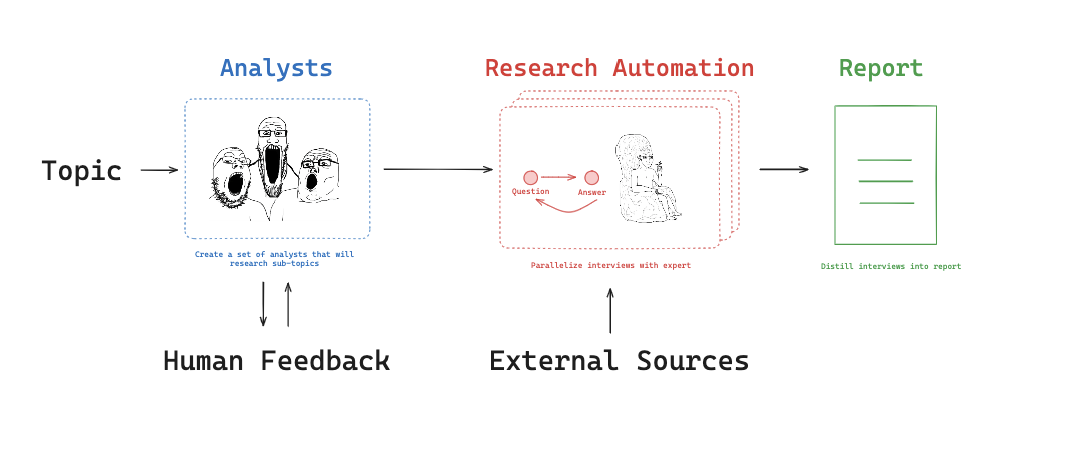

In [38]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai pypdf langchain_community langchain_core scikit-learn tavily-python

## LLM

Ensure your `OPENAI_API_KEY` is set.

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [1]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

## Generate Analysts: Human-In-The-Loop

Create analysts and review them. 

In [2]:
import operator
from typing import List, Optional, Annotated
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph import MessagesState
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

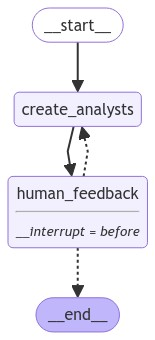

In [3]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

def create_analysts(state: GenerateAnalystsState):
    """ Create analysts """
    
    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')
    
    instructions = SystemMessage(content=f"""
    
    You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

    1. First, review the research topic:
    
    {topic}
            
    2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
            
    {human_analyst_feedback}
      
    3. Determine the most interesting themes based upon documents and / or feedback above.
                        
    4. Pick the top {max_analysts} themes.

    5. Assign one analyst to each theme.""")

    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # Generate question 
    analysts = structured_llm.invoke([instructions]+[HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [4]:
# Input
max_analysts = 3 

topic = '''I want a report focused on the innovations related to the Meta LLlama3.1 work, 
especially on training infrastructue, model architecture, and quantization approaches.'''

thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: OpenAI Research
Role: Training Infrastructure Specialist
Description: Dr. Carter focuses on the development and optimization of large-scale training infrastructure. Her primary concern is to ensure that the infrastructure can handle the computational demands of training advanced models like Meta LLlama3.1 efficiently and cost-effectively.
--------------------------------------------------
Name: Dr. Rajesh Patel
Affiliation: DeepMind
Role: Model Architecture Expert
Description: Dr. Patel specializes in the design and evaluation of neural network architectures. His work involves exploring innovative architectural changes that can improve the performance and efficiency of models like Meta LLlama3.1.
--------------------------------------------------
Name: Dr. Sophia Martinez
Affiliation: Google AI
Role: Quantization Techniques Analyst
Description: Dr. Martinez is an expert in model quantization techniques. She focuses on developing methods to reduce the

In [5]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [6]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                            "Add in someone from a startup to add an entrepreneur perspective"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef64c54-3530-6d00-8002-61abb93a3749'}}

In [7]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Emily Zhang
Affiliation: Meta
Role: Lead Research Scientist
Description: Dr. Zhang focuses on the technical advancements and innovations in model architecture. She is particularly interested in how the new architectural changes in LLlama3.1 improve performance and efficiency.
--------------------------------------------------
Name: Michael Thompson
Affiliation: NVIDIA
Role: Senior Infrastructure Engineer
Description: Michael is an expert in AI training infrastructure. He examines the hardware and software optimizations that support the training of large-scale models like LLlama3.1, including distributed computing and GPU acceleration.
--------------------------------------------------
Name: Samantha Lee
Affiliation: AI Startup InnovateAI
Role: CEO and Co-Founder
Description: Samantha brings an entrepreneurial perspective, focusing on the practical applications and commercialization of innovations in quantization approaches. She is interested in how these advancements can be l

In [8]:
# If we are satisfied, then we simply supply no feedback to end
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef64c54-6013-634c-8004-897c7b26fec2'}}

In [9]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [10]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [11]:
final_state.next

()

In [12]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Dr. Emily Zhang
Affiliation: Meta
Role: Lead Research Scientist
Description: Dr. Zhang focuses on the technical advancements and innovations in model architecture. She is particularly interested in how the new architectural changes in LLlama3.1 improve performance and efficiency.
--------------------------------------------------
Name: Michael Thompson
Affiliation: NVIDIA
Role: Senior Infrastructure Engineer
Description: Michael is an expert in AI training infrastructure. He examines the hardware and software optimizations that support the training of large-scale models like LLlama3.1, including distributed computing and GPU acceleration.
--------------------------------------------------
Name: Samantha Lee
Affiliation: AI Startup InnovateAI
Role: CEO and Co-Founder
Description: Samantha brings an entrepreneurial perspective, focusing on the practical applications and commercialization of innovations in quantization approaches. She is interested in how these advancements can be l

## Conduct Interview

### Generate Question

The analyst will ask questions.

In [13]:
import operator
from typing import List, Optional, Annotated
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph import MessagesState
from pydantic import BaseModel, Field

class InterviewState(MessagesState):
    topic: str # Research topic
    max_num_turns = int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [14]:
def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    instructions = SystemMessage(content=f"""
    
    You are an analyst tasked with interviewing an expert to learn about a specific topic. 

    Your goal is boil down to interesting and specific insights related to your topic.

    1. Interesting: Insights that people will find surprising or non-obvious.
            
    2. Specific: Insights that avoid generalities and include specific examples from the expert.
    
    Here is your topic of focus and set of goals: {analyst.persona}
            
    Begin by introducing yourself using a name that fits your persona, and then ask your question.

    Continue to ask questions to drill down and refine your understanding of the topic.
            
    When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

    Remember to stay in character throughout your response, reflecting the persona and goals provided to you.""")

    # Generate question 
    question = llm.invoke([instructions]+messages)
        
    # Write messages to state
    return {"messages": [question]}

### Generate Answer: Parallelization

The expert will gather information from multiple sources in parallel.

Here we can be very flexible. For example, we can use:

* Specific web sites
* Indexed documents
* Web search

You can try different search tools. [Tavily](https://tavily.com/) is one nice option to consider.
 
Ensure your `TAVILY_API_KEY` is set.

In [ ]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

In [16]:
# Web sites
from langchain_community.document_loaders import WebBaseLoader
url = "https://about.fb.com/news/2024/07/open-source-ai-is-the-path-forward/"
EXPERT_DOC_CONTEXT = WebBaseLoader(url).load()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [17]:
# Index (TODO: Add this to state)
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings

# Load llama3.1 paper (pdf)
loader = PyPDFLoader("../assistant/docs/llama3_1.pdf")
pages = loader.load_and_split()

# Embeddings
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

# Full paper, except for references 
all_pages_except_references=pages[:100]

# Index
vectorstore = SKLearnVectorStore.from_documents(all_pages_except_references, embedding=embeddings)

# Build retriever
retriever = vectorstore.as_retriever(k=10)

In [18]:
# Web search tool

from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

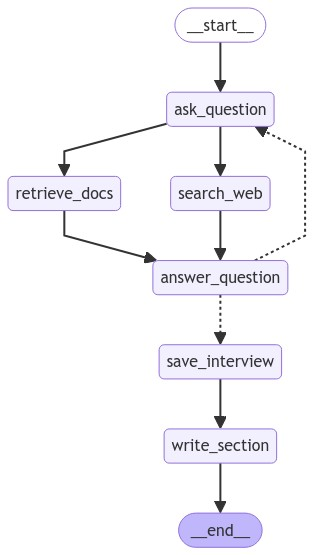

In [19]:
from langchain_core.documents import Document
from langchain_core.messages import get_buffer_string

# Search query writing
instructions = SystemMessage(content=f"""

You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def retrieve_docs(state: InterviewState):
    
    """ Get docs """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([instructions]+state['messages'])
    
    # Retrieve
    docs = retriever.invoke(search_query.search_query)

    # Format
    formatted_retrieved_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

    return {"context": [formatted_retrieved_docs]} 

    formatted_retrieved_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in EXPERT_DOC_CONTEXT
        ]
    )
    
    return {"context": [formatted_retrieved_docs]} 

def search_web(state: InterviewState):
    
    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([instructions]+state['messages'])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def generate_answer(state: InterviewState):
    
    """ Node to answer a question """

    # Get state
    topic = state["topic"]
    messages = state["messages"]
    context = state["context"]

    instructions = SystemMessage(content=f"""
    
    You are an expert being interviewed by an analyst who focused on learning this topic: {topic}. 
            
    You goal is to answer a question posed by the interviewer.

    To answer question, use this context:
            
    {context}

    When answering questions, follow these guidelines:
            
    1. Use only the information provided in the context. 
            
    2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

    3. The context contain sources at the topic of each individual document.

    4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

    5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
            
    6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
            
    [1] assistant/docs/llama3_1.pdf, page 7 
            
    And skip the addition of the brackets as well as the Document source preanble in your citation.""")
   
    # Answer question
    answer = llm.invoke([instructions]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]

    instructions = SystemMessage(content=f"""You are an expert technical writer. 
            
    Your task is to create a short, easily digestible section of a report based on a set of source documents.

    1. Analyze the content of the source documents: 
    - The name of each source document is at the start of the document, with the <Document tag.
            
    2. Create a report structure using markdown formatting:
    - Use ## for the section title
    - Use ### for sub-section headers
            
    3. Write the report following this structure:
    a. Title (## header)
    b. Summary (### header)
    c. Sources (### header)

    4. Make your title engaging based upon the focus area of the analyst: 
    {analyst.description}

    4. For the summary section:
    - Set up summary with general background / context related to the focus area of the analyst
    - Emphasize what is novel, interesting, or surprising about insights gathered from the interview
    - Create a numbered list of source documents, as you use them
    - Do not mention the names of interviewers or experts
    - Aim for approximately 400 words maximum
    - Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
            
       
    6. In the Sources section:
    - Include all sources used in your report
    - Provide full links to relevant websites or specific document paths
    - Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
    - It will look like:

    ### Sources
    [1] Link or Document name
    [2] Link or Document name

    7. Be sure to combine sources. For example this is not correct:

    [3] https://ai.meta.com/blog/meta-llama-3-1/
    [4] https://ai.meta.com/blog/meta-llama-3-1/

    There should be no redundant sources. It should simply be:

    [3] https://ai.meta.com/blog/meta-llama-3-1/
            
    8. Final review:
    - Ensure the report follows the required structure
    - Include no preamble before the title of the report
    - Check that all guidelines have been followed""")
   
    # Write section using either the gathered source docs from interview, or the interview itself 
    section = llm.invoke([instructions]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("retrieve_docs", retrieve_docs)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "retrieve_docs")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("retrieve_docs", "answer_question")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [20]:
# Pick one analyst
analysts[0]

Analyst(affiliation='Meta', name='Dr. Emily Zhang', role='Lead Research Scientist', description='Dr. Zhang focuses on the technical advancements and innovations in model architecture. She is particularly interested in how the new architectural changes in LLlama3.1 improve performance and efficiency.')

In [21]:
from IPython.display import Markdown

# Test
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
initial_state = {"analyst": analysts[0], "messages": messages}
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke(initial_state, thread)
Markdown(interview['sections'][0])

## Llama 3.1: Pioneering Advancements in Model Architecture

### Summary

The Llama 3.1 model, developed by Meta, represents a significant leap in the field of large language models (LLMs). This new iteration builds upon the foundation of its predecessors, introducing several architectural and operational enhancements that improve performance and efficiency. The Llama 3.1 model is particularly notable for its extensive parameter count, increased context window, and innovative quantization techniques.

Llama 3.1 is a dense Transformer model with 405 billion parameters and a context window of up to 128,000 tokens. This model supports multilinguality, coding, reasoning, and tool usage, making it a versatile tool for a wide range of AI tasks. The model's architecture includes 126 layers, a token representation dimension of 16,384, and 128 attention heads, optimized for a training budget of 3.8×10²⁵ FLOPs [1].

Key innovations in Llama 3.1 include:

1. **Enhanced Data and Scale**: Llama 3.1 was pre-trained on a corpus of approximately 15 trillion multilingual tokens, a significant increase from the 1.8 trillion tokens used for Llama 2. This extensive dataset, combined with a rigorous pre-processing and curation pipeline, ensures high-quality training data [1].

2. **Quantization Techniques**: Meta introduced an official FP8 quantized version of Llama 3.1 405B, which applies FP8 quantization to major linear operators of the model. This approach covers 75% of the inference FLOPs, achieving minimal accuracy degradation while significantly improving efficiency [2].

3. **Tool Integration and Zero-Shot Capabilities**: Llama 3.1 supports zero-shot tool use, allowing it to integrate seamlessly with tools it has not encountered during training. This capability extends to generating tool calls for specific tasks such as search, image generation, code execution, and mathematical reasoning [3].

4. **Multimodal Capabilities**: Experiments have shown that Llama 3.1 can integrate image, video, and speech capabilities using a compositional approach. This integration allows the model to perform competitively with state-of-the-art systems on various recognition tasks [1].

5. **Performance Benchmarks**: Llama 3.1 demonstrates superior performance across multiple benchmarks. For instance, it achieves high scores on the ARC Challenge and MMLU benchmarks, outperforming many competing models [1].

6. **Infrastructure and Efficiency**: The training of Llama 3.1 leveraged Meta's advanced AI infrastructure, including the use of up to 16,000 H100 GPUs and a robust storage and network setup. This infrastructure supports the model's extensive computational requirements and ensures efficient training processes [1].

In summary, Llama 3.1's advancements in model architecture, data handling, and computational efficiency mark it as a leading contender in the realm of large language models. Its ability to handle extensive context windows, integrate multimodal capabilities, and perform zero-shot tool use sets a new standard for AI model performance and versatility.

### Sources
[1] ../assistant/docs/llama3_1.pdf  
[2] https://huggingface.co/blog/llama31  
[3] https://www.ibm.com/blog/meta-releases-llama-3-1-models-405b-parameter-variant/  
[4] https://www.datacamp.com/blog/llama-3-1-405b-meta-ai  
[5] https://datasciencedojo.com/blog/meta-llama-3-1/  
[6] https://ai.meta.com/blog/meta-llama-3/  
[7] https://medium.com/@nikita04/metas-llama-3-1-outperforming-the-competition-4f44af127957

### Parallelze interviews: Map-Reduce

We parallelize the interviews via the `Send()` API, a map step.

We combine them into the report body in a reduce step.

### Reflection

We add a final step to reflect on the sections.

And we write an intro and conclusion. 

In [22]:
import operator
from typing import List, Optional, Annotated
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph import MessagesState
from pydantic import BaseModel, Field

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

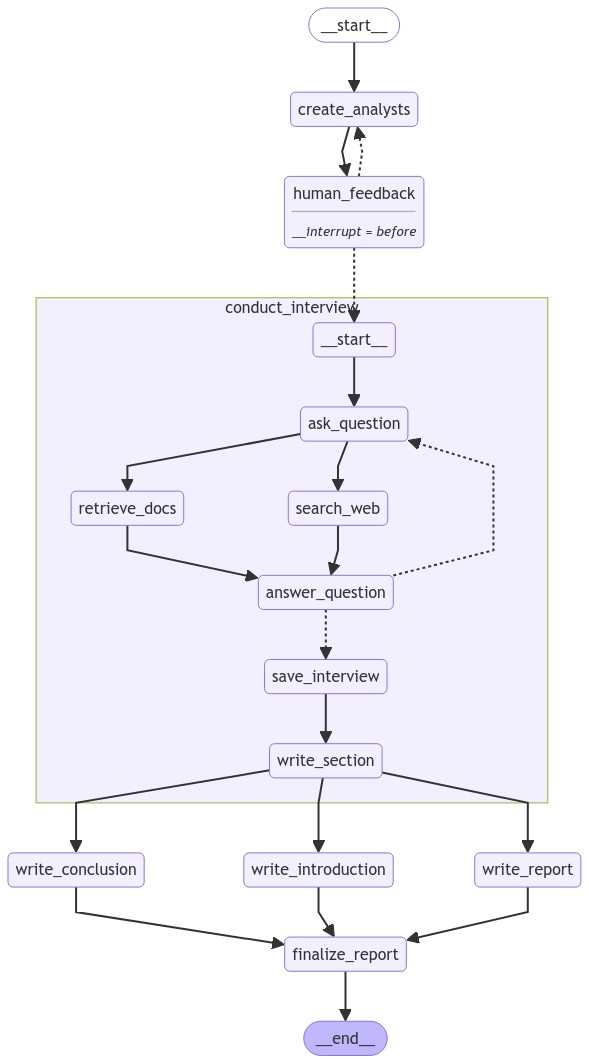

In [39]:
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """    

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]

report_instructions_template = """You are a technical writer finishing a report on {topic}
    
You will be given several memos, each written by an individual analyst.

You job is to consolidate these into a crisp, overall report that ties together the memos. 

The report should summarize the central points in each memo, and it can use narrative form to do this.

Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].

Use markdown formatting. 

Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.

List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Include no pre-amble for the report.

For your report, use the ## Insights header.

Here are the memos to summarize: {formatted_str_sections}"""

def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    report_instructions = report_instructions_template.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=report_instructions)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}


instructions_template = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = instructions_template.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = instructions_template.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

    


def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n" + content + "\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [41]:
# Inputs
max_analysts = 3 

topic = '''The benefits of adopting LangGraph as an agent framework'''

thread = {"configurable": {"thread_id": "8"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: Technology Adoption Specialist
Description: Dr. Carter focuses on the strategic benefits and challenges of adopting new technologies in enterprise environments. She is particularly interested in how LangGraph can streamline operations and improve efficiency.
--------------------------------------------------
Name: Raj Patel
Affiliation: Data Science Insights
Role: Data Scientist
Description: Raj Patel is a data scientist who explores the technical advantages of using LangGraph for data analysis and machine learning. He is keen on understanding how LangGraph can enhance data processing capabilities and model performance.
--------------------------------------------------
Name: Linda Martinez
Affiliation: Future Systems Lab
Role: AI Ethics Researcher
Description: Linda Martinez investigates the ethical implications of adopting AI frameworks like LangGraph. Her focus is on ensuring that the use of LangGraph aligns with ethical

In [42]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                            "Add in the CEO of gen ai native startup"}, as_node="human_feedback")

{'configurable': {'thread_id': '8',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef64e0e-34ae-647a-8002-bc873fc54b48'}}

In [43]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Alex Thompson
Affiliation: Gen AI Native Startup
Role: CEO
Description: Alex is the CEO of a startup that specializes in generative AI technologies. He is focused on leveraging cutting-edge frameworks like LangGraph to enhance the capabilities of his company's AI solutions. His primary concerns include scalability, ease of integration, and the potential for LangGraph to accelerate product development cycles.
--------------------------------------------------
Name: Dr. Emily Carter
Affiliation: Tech Research Institute
Role: Senior Research Scientist
Description: Dr. Carter is a senior research scientist at a leading tech research institute. Her work revolves around the practical applications of AI frameworks in various industries. She is particularly interested in the performance improvements and innovative features that LangGraph offers, as well as its impact on research and development efficiency.
--------------------------------------------------
Name: Michael Lee
Affiliation: 

In [44]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback": 
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '8',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef64e0e-5109-6b42-8004-d2aa56883bec'}}

In [45]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_introduction
--Node--
write_conclusion
--Node--
write_report
--Node--
finalize_report


In [46]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# The Benefits of Adopting LangGraph as an Agent Framework

## Introduction

In the rapidly evolving field of generative AI, selecting the right framework is crucial for scalability, ease of integration, and accelerated product development. This report explores the capabilities of LangGraph and the Llama 3 family of models, highlighting their potential to meet these needs. LangGraph's graph-based approach allows for complex, flexible agent behaviors, making it ideal for sophisticated AI applications. Llama 3, developed by Meta AI, offers advanced capabilities in multilinguality, coding, reasoning, and tool usage. Together, these technologies promise to enhance scalability, performance, and integration, significantly accelerating product development cycles.



### Leveraging LangGraph and Llama 3 for Advanced AI Solutions

In the rapidly evolving field of generative AI, frameworks like LangGraph and the Llama 3 family of models are gaining significant attention for their potential to enhance AI solutions. Alex, the CEO of a startup specializing in generative AI, is particularly interested in these technologies for their scalability, ease of integration, and ability to accelerate product development cycles.

#### LangGraph's Unique Approach

LangGraph is a cutting-edge framework designed for creating controlled, production-ready AI applications. Unlike traditional frameworks that view agents as static objects, LangGraph conceptualizes agents as dynamic graphs, allowing for more complex and flexible behaviors. This approach is particularly beneficial for developing sophisticated AI chat agents and other multi-agent workflows, offering advantages in cycles, controllability, and persistence [1][2][3].

#### Llama 3's Advanced Capabilities

The Llama 3 family of models, developed by Meta AI, represents a significant advancement in foundation models. These models are designed to support a wide range of AI tasks, including multilinguality, coding, reasoning, and tool usage. The largest model in the Llama 3 family boasts 405 billion parameters and a context window of up to 128K tokens, making it one of the most powerful models available today. The development process of Llama 3 includes extensive pre-training and post-training stages, ensuring the models are well-aligned with human preferences and capable of performing complex tasks [4][5].

#### Scalability and Performance

Both LangGraph and Llama 3 are built with scalability in mind. LangGraph's framework supports the development of stateful, multi-actor applications, making it suitable for large-scale deployments. Similarly, the Llama 3 models are trained on massive datasets and optimized for performance, ensuring they can handle high-demand applications without compromising on quality [1][4].

#### Ease of Integration

LangGraph offers a high degree of controllability and persistence, making it easier to integrate into existing workflows. The framework's ability to handle cycles and complex agent behaviors simplifies the development process, allowing for quicker iterations and faster deployment of AI solutions. Llama 3's robust architecture and extensive documentation further facilitate seamless integration into various applications [1][2][4].

#### Accelerating Product Development

The combination of LangGraph's flexible framework and Llama 3's powerful models can significantly accelerate product development cycles. By leveraging these technologies, Alex's startup can develop more advanced AI solutions in a shorter timeframe, staying ahead of the competition and meeting the growing demands of the market [1][4][5].

### LangGraph and Llama 3: Revolutionizing AI Applications

Dr. Carter, a senior research scientist at a leading tech research institute, focuses on the practical applications of AI frameworks in various industries. Her interest lies in performance improvements and innovative features that AI frameworks like LangGraph and Llama 3 offer, as well as their impact on research and development efficiency.

#### Performance Benchmarks

Llama 3 models, particularly the 405B parameter version, perform on par with leading language models like GPT-4 across various tasks, including coding, reasoning, and tool usage. The models have shown significant improvements in multilingual tasks and long-context understanding [4].

#### Innovative Training Techniques

Llama 3 employs synthetic data generation and execution feedback to enhance its coding capabilities. This involves generating programming problems, solutions, and iterative self-correction based on feedback from static and dynamic analysis techniques [4][5].

#### Tool Integration

Llama 3 can use tools like the Wolfram Alpha API to solve complex math and science problems. The model is trained to generate correct tool calls in zero-shot scenarios, making it highly versatile in multi-turn dialogues and complex problem-solving tasks [4][5].

#### Multimodal Capabilities

Llama 3 is being extended to handle image, video, and speech recognition tasks through a compositional approach. These multimodal models are still under development but show competitive performance with state-of-the-art models in initial experiments [4].

#### Human Feedback and Safety

The post-training process of Llama 3 involves supervised fine-tuning and Direct Preference Optimization (DPO) to align the model with human feedback. Safety mitigations are also incorporated to ensure the model's helpfulness and harmlessness [4][5].

The combination of LangGraph's robust framework for building multi-agent workflows and Llama 3's advanced language modeling capabilities presents a powerful toolkit for developing intelligent, efficient, and safe AI applications. These innovations are poised to significantly impact research and development efficiency across various industries.

### Integrating LangGraph with Llama 3: A Path to Robust AI Solutions

Michael, the CTO of a large enterprise software company, is tasked with integrating new technologies into the company's product suite, focusing on robustness, security, and long-term viability. One promising technology is LangGraph, a framework that enables developers to create state machines where large language models (LLMs) act as reasoning engines. This report explores the potential of integrating LangGraph with the Llama 3 family of models to enhance AI-driven solutions.

#### Enhanced Multimodal Capabilities

Preliminary experiments with integrating image, video, and speech capabilities into Llama 3 using a compositional approach have shown promising results. This could be further enhanced by LangGraph's ability to manage complex workflows [3].

#### Improved Safety and Security

Llama 3 incorporates several safety mitigations, including Llama Guard, which reduces violation rates and false refusals. LangGraph can complement these features by providing additional layers of control and customization for developers [4][5].

#### Scalability and Efficiency

The combination of LangGraph's state machine approach and Llama 3's scalable architecture can lead to more efficient and scalable AI solutions. This is particularly important for enterprise applications that require high performance and reliability [1][2][4].

#### Real-time Responsiveness

Llama 3's token-wise streaming capability, which maintains low latency during inference, can be leveraged by LangGraph to create more responsive and real-time AI applications [4].

In conclusion, the integration of LangGraph with Llama 3 presents a compelling opportunity for developing robust, secure, and scalable AI-driven solutions. This combination can address the complex needs of enterprise applications, providing a solid foundation for future innovations.


## Conclusion

The adoption of LangGraph as an agent framework, combined with the advanced capabilities of the Llama 3 family of models, offers a transformative approach to developing AI solutions. LangGraph's unique graph-based conceptualization of agents enables the creation of complex, flexible behaviors, making it ideal for sophisticated AI applications. The Llama 3 models, with their extensive pre-training and post-training processes, provide robust support for a wide range of tasks, including multilinguality, coding, and reasoning.

Key insights highlight the scalability, performance, and ease of integration offered by both LangGraph and Llama 3. These technologies not only accelerate product development cycles but also ensure robust, secure, and scalable AI-driven solutions. By leveraging LangGraph and Llama 3, organizations can stay ahead of the competition and meet the growing demands of the market, ultimately revolutionizing the landscape of AI applications.

## Sources
[1] https://opendatascience.com/langgraph-the-future-of-production-ready-ai-agents/  
[2] https://danielwcovarrubias.medium.com/building-custom-agents-with-langgraph-an-overview-d0c4b55fcc72  
[3] https://adasci.org/a-practical-guide-to-building-ai-agents-with-langgraph/  
[4] ../assistant/docs/llama3_1.pdf  
[5] https://github.com/langchain-ai/langgraph  
[6] https://www.langchain.com/langgraph  
[7] https://towardsdatascience.com/from-basics-to-advanced-exploring-langgraph-e8c1cf4db787  
[8] https://www.datacamp.com/tutorial/langgraph-tutorial  
[9] https://www.analyticsvidhya.com/blog/2024/03/build-an-ai-coding-agent-with-langgraph-by-langchain/

We can look at the trace:

https://smith.langchain.com/public/1e15bac6-b361-47c6-a9a5-994fbf12670e/r